In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.4 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-bm1cfq2h
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-bm1cfq2h
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 15.50 MiB/s, done.
Updating files: 100% (12939/12939), done.


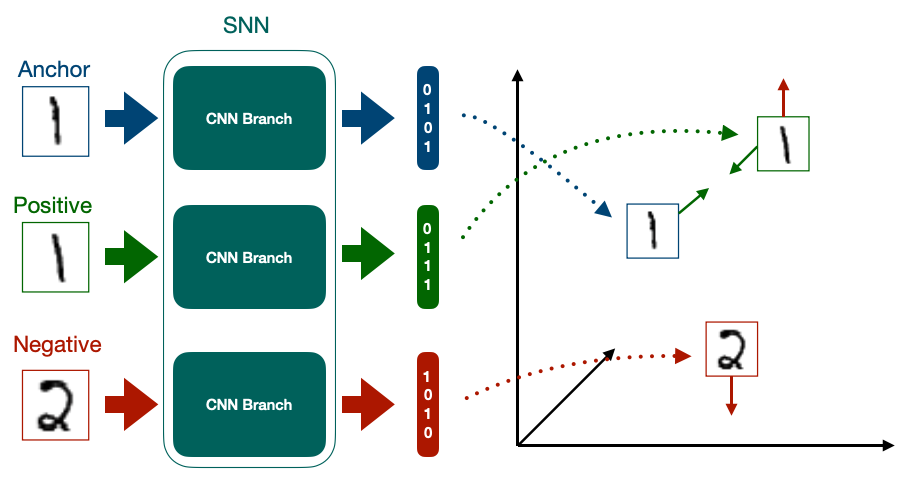

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001  # Learning Rate
EPOCHS = 15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[25]

# Reading images as a numpy ndarrary
A_img = io.imread(DATA_DIR + row['Anchor'])
P_img = io.imread(DATA_DIR + row['Positive'])
N_img = io.imread(DATA_DIR + row['Negative'])

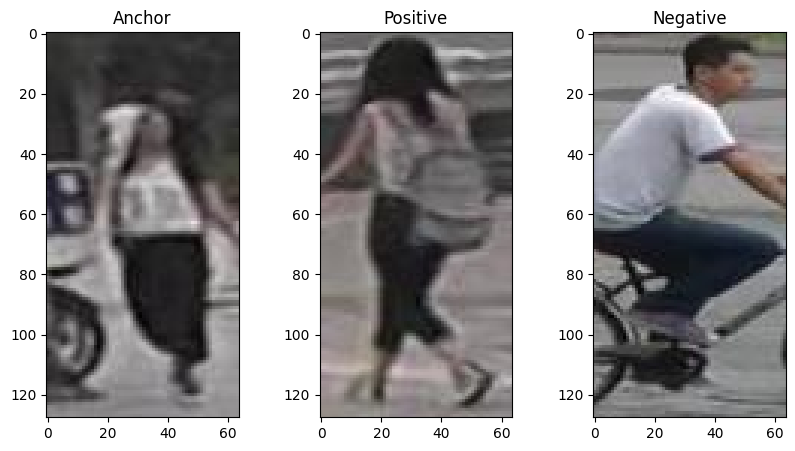

In [ ]:
# Plot - f of 1 row and 3 columns with total plot size of 10 x 5, in each of the axes we are showing the images we loaded
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset

In [ ]:
# Creating class for the dataset to create a PyTorch Dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row['Anchor'])
    P_img = io.imread(DATA_DIR + row['Positive'])
    N_img = io.imread(DATA_DIR + row['Negative'])

    # Convert each of the images from numpy.ndarrary to Pytorch Tensor format
    # Numpy supports best math operation on CPU
    # Tensor though similar to Numpy Arrary are optimized to for GPU accelerated computation with PyTorch support
    # Tensors support calculation of gradient automatically which is needed for Deep Learning and backpropagations
    # Numpy - Best for Data Manipulations & Preprocessing
    # Tensors - Best for Deep Learning - Neural Network Training
    # Permute changes the dimensions from (Height, Width, Color) to (Color, Height, Width)
    # Color is actually the image channel, depending on the image it can be
    #   - Grayscale image → 1 channel (just intensity/brightness).
    #   - RGB image → 3 channels: Red, Green, Blue.
    #   - RGBA image → 4 channels: Red, Green, Blue, Alpha (transparency).
    # Reason why we permute is the PyTorch convolution layers are designed in a way to expect the channel first
    # Convolution layers in PyTorch are implemented to work with (N, C, H, W) format, where
    #     - N = batch size
    #     - C = channels
    #     - H = height
    #     - W = width
    # Then by dividing with 255.0 we normalize to float points from 0 to 1
    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


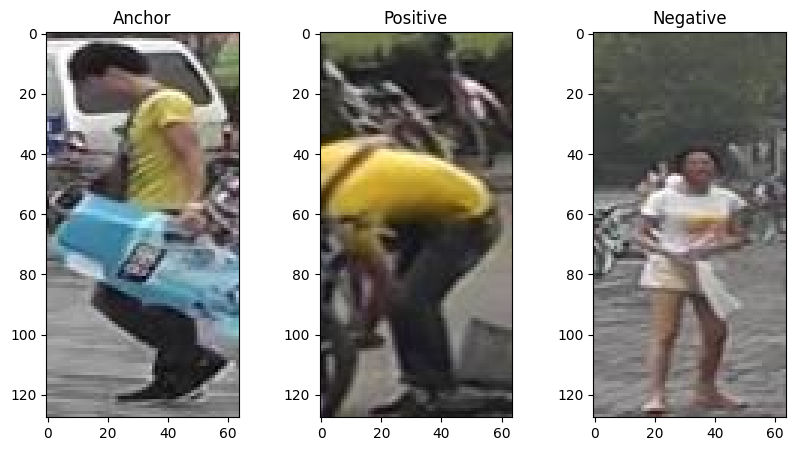

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
# DataLoader create mini subsets of the data to pass to the model training in parallel
# Without Dataloader we need to manually create the batches and send for training
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  print(f"Shape of A : {A.shape}")
  print(f"Shape of P : {P.shape}")
  print(f"Shape of N : {N.shape}")
  break

print(f"One image batch shape : {A.shape}")

Shape of A : torch.Size([32, 3, 128, 64])
Shape of P : torch.Size([32, 3, 128, 64])
Shape of N : torch.Size([32, 3, 128, 64])
One image batch shape : torch.Size([32, 3, 128, 64])


## EfficientNet and ResNet are two famous Convolutional Neural Network Architectures

1. ResNet
- As you add more layers to a Deep Neural network it should becomde better
- But during training as the layers increase suffer with vanishing gradients making training unstable and accuracy gets worse
- Basically we backpropogate and check the gradients of loss with respect to weights
- Based on the gradient we calculate how much to adjust the weights
- But if layers increase the multiplications done over each layer for calculating the gradient will make the value to become close to zero, this makes the layers close to input layer have almost zero gradient and making model/network fail to learn. This is vanishing graidents problem
- This is more common with activation function sigmoid and tanh
- So we use ReLU activation function , Batch Normalization and Residual Connection (ResNet)
- In general the input for current layer will the output of the previous layer which during claculation of the gradient makes the value close to zero as the layers increase
- With ResNet we will pass the input of previous layer + Output of previoud layer as the input of current layer
- This way the gradient calculation at each layer will be a significant value making the weight adjustment larger therby increasing the chances of learning faster
- We have different types of ResNets
  - ResNet-18
  - ResNet-34
  - ResNet-50  - Popular for Transfer Learning
  - ResNet-101 - Similar to 50, higher accuracy but more computation
  - ResNet-152
  - ResNet-1202 - For research


2. EfficientNet
- CNNs increase the depth, width or input resolution for more accuracy
  - Depth - more layers
  - Width - More channels
  - Larger Input - high resolution images
- But increasing one will not help
- Efficient net scales all 3 together in a blanced by using a overall scalling coefficient (ϕ)
- This makes it faaster to train then traditional CNNs to get better accuracy
- ϕ determines the type of EfficientNet (B0,B1,B2,..B7)

## Activation Function

- A way to introduce non linearity to the input
- Each layer has weights , input and bias. Weights x Input + Bias is the Weighted Sum at each input layer
- Now we apply activation function to the weighted sum to introduce non-linearity to predict the output of that layer.
- Common Activation Functions
  - Signmoid - S-Shaped Curve Function
  - Tanh - Hyperbolic Tangent
  - ReLU - Rectified Linear Unit
  - SoftMax - Uses the probability of each input dimension
  - Leaky ReLU - A little fix to ReLU so to avoid making a neuron completly dead if they go less than zero

Sigmoid --> σ(x)=1/ (1+e^(−x1​))

tanh(x) -->  e^x+e^(−x) / e^x − e^(−x)​

ReLU(x)=max(0,x)

LeakyReLU(x)
  - if x>0 --> x
  - if x≤0 --> αx
  - α small value (eg - 0.001)

Softmax(xi)=e^xi / ∑e^xj
  - Basically this creates the probability of each of the dimension

### Learning Rate - Pace at which the weight adjustment must be done
### Epochs - Number of iteration done for the training
### Batch Size - Amount of data the networks trains on parallel

## Loss Function
- For calculating the gradients of the prediction from the true values during backpropagation

## Optimizer

## Regularization Techniques

## Momentum or Weight Decay or Regularization Term

## Learning Rate Scheduler
## Early Stopping
## Gradient Clipping
## Weight Initialization

# Create Model

In [ ]:
class APN_Model(nn.Module):
  def __init__(self,embed_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=embed_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() # ON Dropout
  total_loss = 0.0

  for A,P,N in tqdm(dataloader):
    A = A.to(DEVICE)
    P = P.to(DEVICE)
    N = N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [ ]:
def eval_fn(model, dataloader, criterion):
  model.eval() # OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A = A.to(DEVICE)
      P = P.to(DEVICE)
      N = N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED WEIGHTS SUCCESS")

  print(f"Epoch : {epoch+1}")
  print(f"Train Loss : {train_loss}")
  print(f"Valid Loss : {valid_loss}")

100%|██████████| 25/25 [00:02<00:00,  8.40it/s]


SAVED WEIGHTS SUCCESS
Epoch : 1
Train Loss : 0.6125919845700264
Valid Loss : 0.4013903570175171


100%|██████████| 25/25 [00:02<00:00,  8.57it/s]


Epoch : 2
Train Loss : 0.2890630477666855
Valid Loss : 0.44292465448379514


100%|██████████| 25/25 [00:02<00:00,  8.57it/s]


Epoch : 3
Train Loss : 0.18152080722153185
Valid Loss : 0.4280500674247742


100%|██████████| 25/25 [00:02<00:00,  8.56it/s]


SAVED WEIGHTS SUCCESS
Epoch : 4
Train Loss : 0.18447726398706435
Valid Loss : 0.2138160562515259


100%|██████████| 25/25 [00:02<00:00,  8.59it/s]


SAVED WEIGHTS SUCCESS
Epoch : 5
Train Loss : 0.07931231796741485
Valid Loss : 0.16975881963968276


100%|██████████| 25/25 [00:02<00:00,  8.78it/s]


Epoch : 6
Train Loss : 0.06459686242043972
Valid Loss : 0.18466635912656784


100%|██████████| 25/25 [00:02<00:00,  8.80it/s]


Epoch : 7
Train Loss : 0.06363753840327263
Valid Loss : 0.1811243087053299


100%|██████████| 25/25 [00:02<00:00,  8.84it/s]


SAVED WEIGHTS SUCCESS
Epoch : 8
Train Loss : 0.061501275673508646
Valid Loss : 0.10929492890834808


100%|██████████| 25/25 [00:02<00:00,  8.62it/s]


Epoch : 9
Train Loss : 0.05891325145959854
Valid Loss : 0.219834743142128


100%|██████████| 25/25 [00:02<00:00,  8.92it/s]


Epoch : 10
Train Loss : 0.05057358995079994
Valid Loss : 0.14770942479372023


100%|██████████| 25/25 [00:02<00:00,  8.68it/s]


Epoch : 11
Train Loss : 0.04421180337667465
Valid Loss : 0.1949501532316208


100%|██████████| 25/25 [00:02<00:00,  8.54it/s]


Epoch : 12
Train Loss : 0.04095886096358299
Valid Loss : 0.16313099682331086


100%|██████████| 25/25 [00:02<00:00,  8.35it/s]


Epoch : 13
Train Loss : 0.04031690657138824
Valid Loss : 0.22901045322418212


100%|██████████| 25/25 [00:02<00:00,  8.86it/s]


Epoch : 14
Train Loss : 0.04033159837126732
Valid Loss : 0.13970846593379974


100%|██████████| 25/25 [00:02<00:00,  8.43it/s]

Epoch : 15
Train Loss : 0.03966169312596321
Valid Loss : 0.1382036352157593


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []
  model.eval()
  with torch.no_grad():
    for img_name in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + img_name)
      A = torch.from_numpy(A).permute(2,0,1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)
  return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))

df_enc = get_encoding_csv(model, df['Anchor'])
df_enc.to_csv('anc_encodings.csv', index = False)

100%|██████████| 4000/4000 [00:44<00:00, 90.16it/s] 


In [ ]:
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.280753,0.288673,-0.051999,0.021760,-1.785108,-0.597016,0.936830,-0.418984,0.136654,...,-0.876354,0.480052,-0.117799,-0.467233,0.274132,0.781099,-0.331882,0.086123,0.152912,-0.377823
1,1420_c3s3_061978_03.jpg,0.500152,0.143545,-0.226339,-0.190936,-0.922493,-1.111850,1.028826,-0.389692,0.178575,...,-0.437804,0.283233,-0.073996,-0.842501,0.260761,0.347363,-0.219197,-0.350745,-0.010189,-0.574540
2,1420_c5s3_062565_05.jpg,0.499396,0.270518,-0.293993,-0.260116,-1.239402,-1.202803,1.764628,-0.461990,-0.166627,...,-0.702755,0.171822,-0.058998,-0.974879,0.380255,0.223497,-0.722679,-0.444159,-0.209442,-0.836625
3,1420_c6s3_085592_04.jpg,0.184053,0.444182,-0.311225,0.003903,-1.808165,-0.728020,1.074780,-0.434264,0.103474,...,-1.273393,0.431810,0.095686,-0.336146,0.527372,0.913106,-1.009698,0.259665,0.102880,-0.388132
4,0663_c5s3_085987_03.jpg,-0.795539,-0.198243,0.263096,-0.463165,-0.276165,0.191585,0.042112,0.263506,-0.894445,...,-0.511539,-0.395368,0.325680,0.593452,-0.147579,-0.535069,-0.603525,-0.319319,-0.432517,0.727907


# Inference

In [ ]:
def euclidean_distance(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.squeeze().cpu().detach().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_distance(img_enc, anc_enc_arr[i: i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.12/dist-packages/networkx/drawing/layout.py:982: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


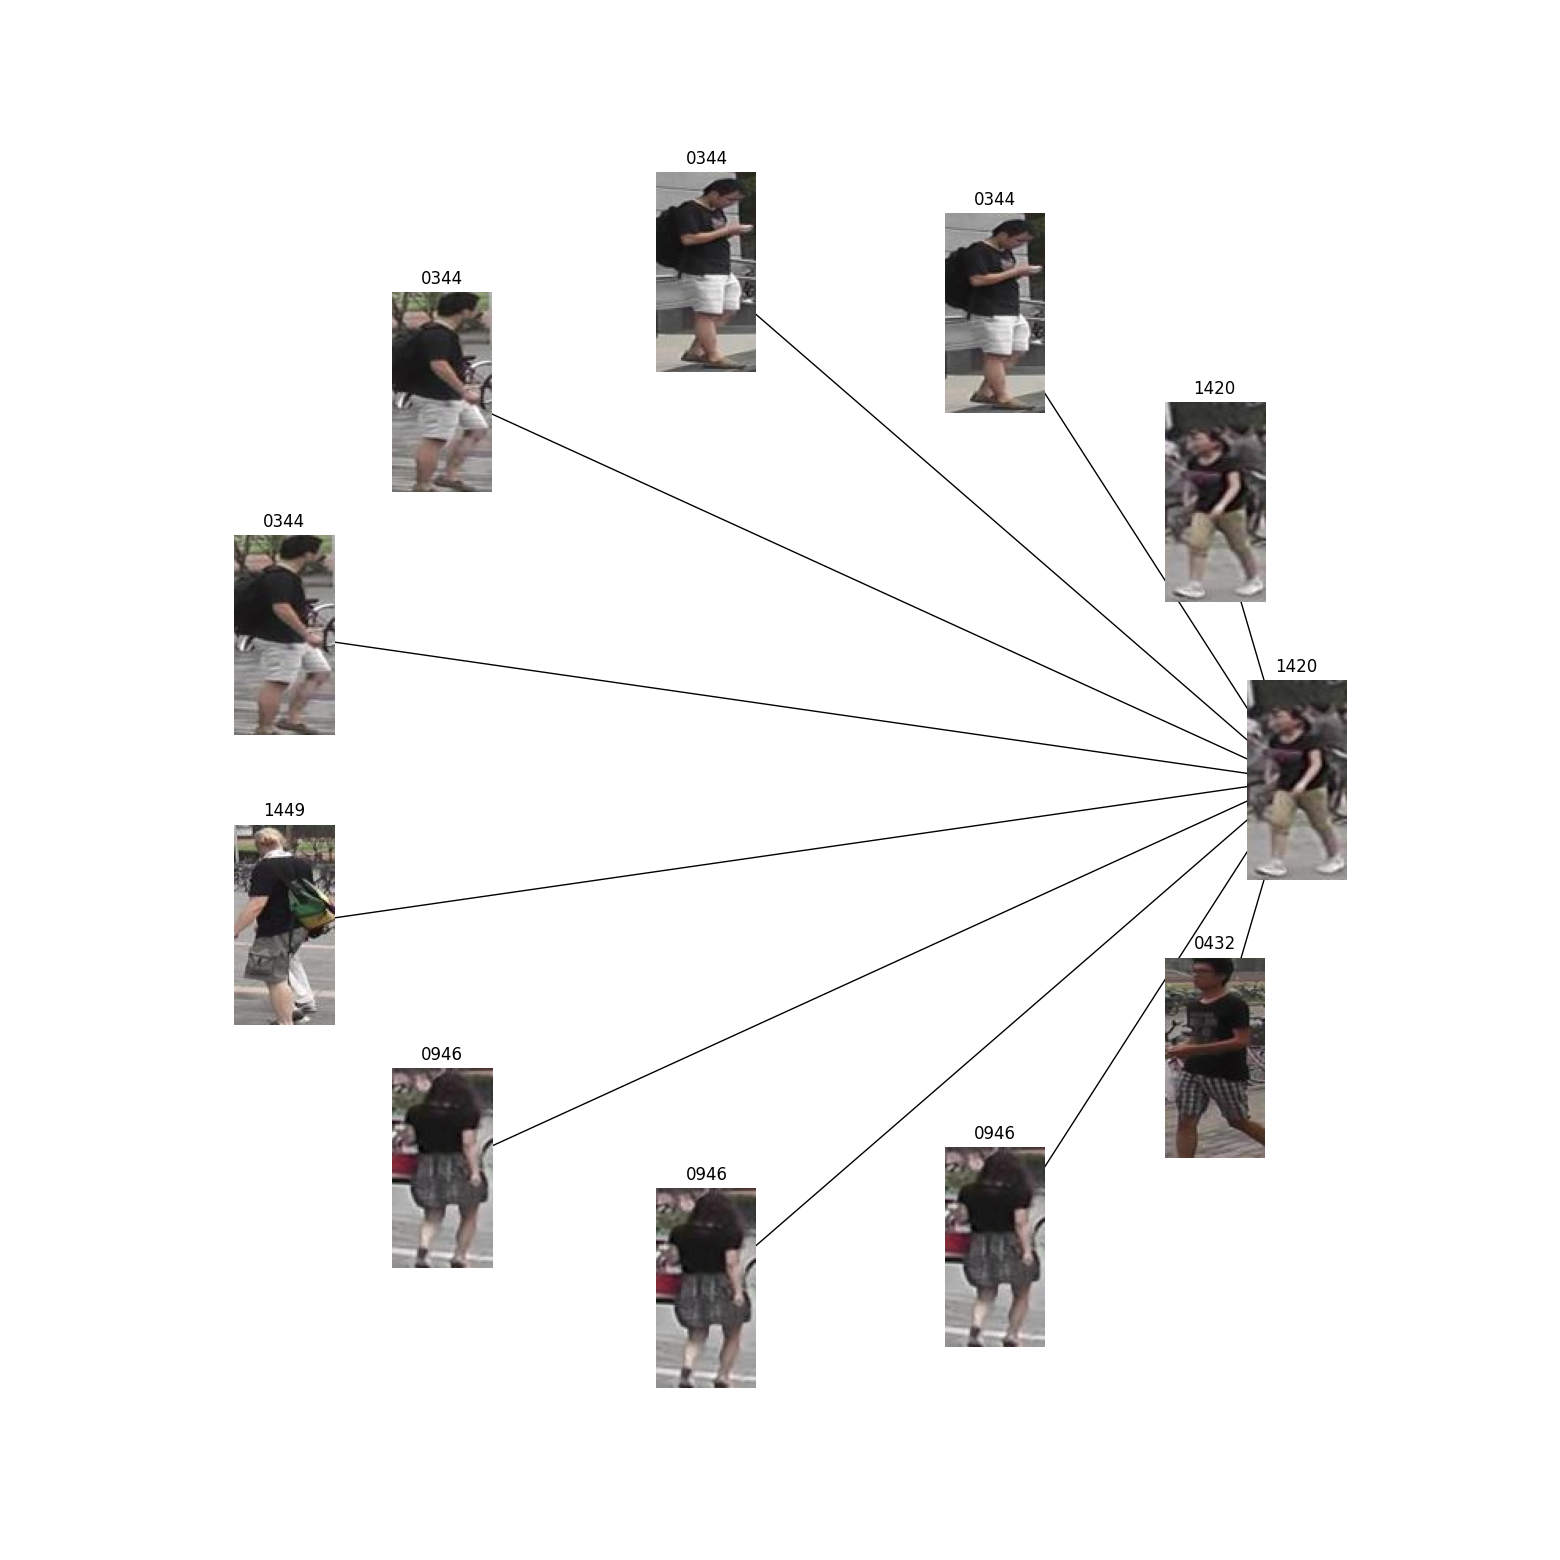

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);